In [76]:
import keras
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM, Flatten, Conv1D, GlobalAveragePooling1D, MaxPooling1D, Reshape
import progressbar
import numpy as np
import os

def data_generator():
    # train_file = '../data/train.csv'
    chunk_folder = '../data/chunks/'
    while True:
        chunkx = np.zeros((4096, 2))
        chunky = np.zeros((4096, ))
        ii = 0
        for file in os.listdir(chunk_folder):
            df = pd.read_csv(os.path.join(chunk_folder, file))
            data_chunk = df.values[:,0]
            target = np.mean(df.iloc[:,1])
            chunkx = np.zeros((4096, 2 ))
            chunkx[:df.shape[0], :] = df.iloc[:min(df.shape[0], 4096), :]
            chunky = np.zeros((4096, ))
            chunky[:df.shape[0]] = df.iloc[:min(df.shape[0], 4096), 1]
            yield chunkx[:df.shape[0]], chunky[:df.shape[0]]

def generate_single(file):
    input_length = 32
    df = pd.read_csv(os.path.join(chunk_folder, file))
    data_chunk = df.values[:,0]
    target = np.mean(df.iloc[:,1])
    chunkx = np.zeros((4096, input_length ))
    chunky = np.zeros((4096, ))
    imax = 0
    for i in range(df.shape[0]-input_length):
        chunkx[i, :] = df.iloc[i:i+input_length, 0]
        chunky[i] = df.iloc[i, 1]
        imax=i+1
    return chunkx[:imax, :], chunky[:imax]

def get_model():
    # max_features = 2
    input_length = 32
    num_internal_dimensions = 64
    dropout_rate = 0.1
    model = Sequential()
    model.add(Reshape((1, input_length), input_shape=(input_length, )))
    model.add(Dropout(dropout_rate))
    # model.add(Dropout(dropout_rate))
    model.add(Dense(num_internal_dimensions, input_shape=(1, 2), activation='relu'))
    # model.add(Conv1D(64, 2, activation='relu', input_shape=(1, 2), padding='causal'))
    # model.add(Conv1D(64, 2, activation='relu', padding='causal'))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(num_internal_dimensions))
    model.add(Dense(num_internal_dimensions, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Reshape((1, num_internal_dimensions)))
    model.add(LSTM(num_internal_dimensions))
    model.add(Dense(num_internal_dimensions, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Reshape((1, num_internal_dimensions)))
    model.add(Dense(num_internal_dimensions, activation='relu'))
    # model.add(MaxPooling1D(2))
    # model.add(Conv1D(128, 2, activation='relu', padding='causal'))
    # model.add(Conv1D(128, 2, activation='relu', padding='causal'))
    model.add(Flatten())
    # model.add(LSTM(128))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_absolute_error',
              optimizer='adam',
              metrics=['accuracy'])
    try:
        model.load_weights('best_weights.hf5')
    except:
        print('could not load weights')
    print(model.summary())
    return model

model = get_model()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_37 (Reshape)         (None, 1, 32)             0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 1, 32)             0         
_________________________________________________________________
dense_76 (Dense)             (None, 1, 64)             2112      
_________________________________________________________________
dropout_50 (Dropout)         (None, 1, 64)             0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_77 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_51 (Dropout)         (None, 64)                0         
__________

<IPython.core.display.Javascript object>


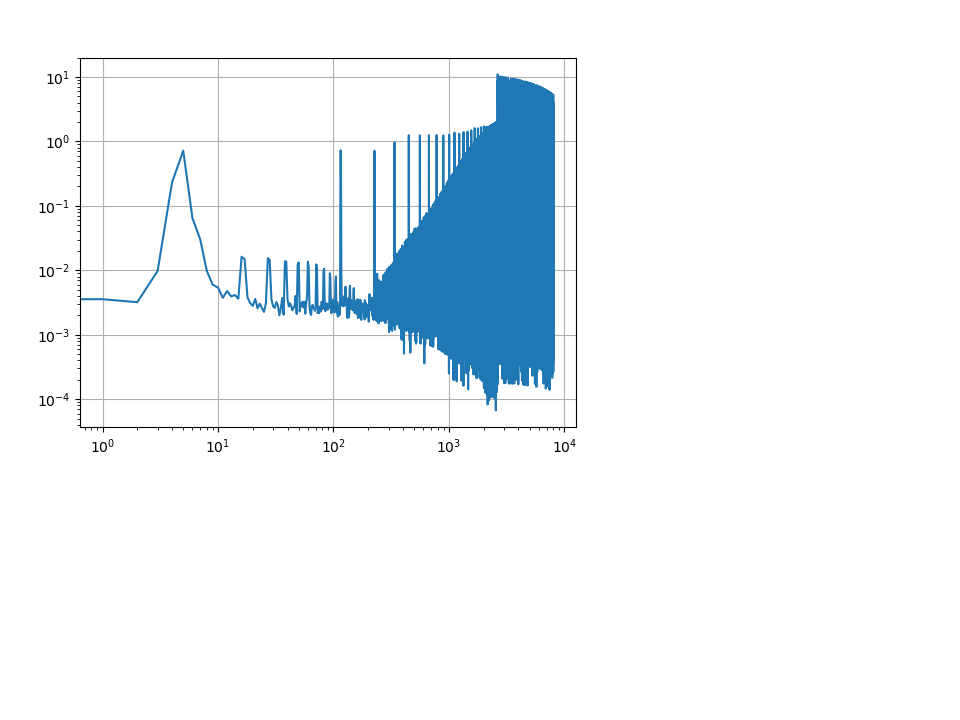

C:\Users\lutz.kuenneke\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
C:\Users\lutz.kuenneke\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:3099: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  self.set_xlim(upper, lower, auto=None)


KeyboardInterrupt: 

In [74]:
%matplotlib notebook
import matplotlib.pyplot as plt

checkpoint = keras.callbacks.ModelCheckpoint('best_weights.hf5', monitor='mean_absolute_error', verbose=0, save_best_only=False, mode='min')
# model.fit_generator(data_generator(), steps_per_epoch=4096, epochs=10000, callbacks=[checkpoint])
chunk_folder = '../data/chunks/'
train_files = os.listdir(chunk_folder)
i_arr = []
loss_arr = []
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
for i, file in enumerate(train_files):
    # print(str(i) + ' ' + file)
    fitx, fity = generate_single(file)
    hist = model.fit(fitx, fity, callbacks=[checkpoint], verbose=0)
    # print(hist.history)
    loss_arr.append(hist.history['loss'][-1])
    i_arr.append(i)
    ax.clear()
    ax.loglog(i_arr, loss_arr)
    ax.grid()
    fig.canvas.draw()

In [ ]:
def get_single(file):
    input_length = 32
    df = pd.read_csv(file)
    data_chunk = df.values[:,0]
    target = np.mean(df.iloc[:,1])
    chunkx = np.zeros((4096, input_length ))
    imax = 0
    for i in range(min(df.shape[0]-input_length, 4096)):
        chunkx[i, :] = df.iloc[i:i+input_length, 0]
        imax=i+1
    return chunkx[:imax, :]


files = os.listdir('../data/test/')
for i, file in enumerate(files):
    pcolname = 'time_to_failure'
    # segid = file.replace('.csv','')
    fullname = os.path.join('../data/test', file)
    xarr = get_single(fullname)
    df = pd.read_csv(fullname)
    ypred = model.predict(xarr)
    print(str(i) + ' ' + file + ' ' + str(ypred[-1][0]))
    # for i in range(len(ypred)):
    #    df['time_to_failure'].iloc[i] = ypred[i]
    df['time_to_failure'] = ypred[-1][0]
    df.to_csv(fullname, index=False)

0 seg_00030f.csv 5.2971272
1 seg_0012b5.csv 5.2971272
2 seg_00184e.csv 5.2971272
3 seg_003339.csv 5.2971272
4 seg_0042cc.csv 5.2971272
5 seg_004314.csv 5.2971272
6 seg_004cd2.csv 5.2971272
7 seg_004ee5.csv 5.2971272
8 seg_004f1f.csv 5.2971272
9 seg_00648a.csv 5.2971272
10 seg_006e4a.csv 5.2971272
11 seg_007a37.csv 5.2971272
12 seg_00a37e.csv 5.2971272
13 seg_00be11.csv 5.2971272
14 seg_00c35b.csv 5.2971272
15 seg_00cc91.csv 5.2971272
16 seg_00e5f7.csv 5.2971272
17 seg_00f3b9.csv 5.2971272
18 seg_010eab.csv 5.2971272
19 seg_0125d9.csv 5.2971272
20 seg_0144cb.csv 5.2971272
21 seg_0165c6.csv 5.2971272
22 seg_016913.csv 5.2971272
23 seg_016cdb.csv 5.2971272
24 seg_017314.csv 5.2971272
25 seg_01a8dc.csv 5.2971272
26 seg_01c775.csv 5.2971272
27 seg_01ecb0.csv 5.2971272
28 seg_02042f.csv 5.2971272
29 seg_025e78.csv 5.2971272
30 seg_032822.csv 5.2971272
31 seg_0339ca.csv 5.2971272
32 seg_037461.csv 5.2971272
33 seg_038879.csv 5.2971272
34 seg_03d386.csv 5.2971272
35 seg_03d63e.csv 5.2971272
36

287 seg_1e572b.csv 5.2971272
288 seg_1e617a.csv 5.2971272
289 seg_1e61d6.csv 5.2971272
290 seg_1e677e.csv 5.2971272
291 seg_1eae76.csv 5.2971272
292 seg_1ebe6b.csv 5.2971272
293 seg_1ece48.csv 5.2971272
294 seg_1eeb8f.csv 5.2971272
295 seg_1ef708.csv 5.2971272
296 seg_1f1e60.csv 5.2971272
297 seg_1f3d44.csv 5.2971272
298 seg_1f3ede.csv 5.2971272
299 seg_1f5240.csv 5.2971272
300 seg_1f7cf8.csv 5.2971272
301 seg_1f9aed.csv 5.2971272
302 seg_1fa983.csv 5.2971272
303 seg_1fc7ab.csv 5.2971272
304 seg_1fe311.csv 5.2971272
305 seg_2005a7.csv 5.2971272
306 seg_2018c8.csv 5.2971272
307 seg_204dc6.csv 5.2971272
308 seg_208ba5.csv 5.2971272
309 seg_2099f4.csv 5.2971272
310 seg_20a990.csv 5.2971272
311 seg_20b8d0.csv 5.2971272
312 seg_20cbac.csv 5.2971272
313 seg_20cc25.csv 5.2971272
314 seg_20d9de.csv 5.2971272
315 seg_20e9ad.csv 5.2971272
316 seg_210388.csv 5.2971272
317 seg_211299.csv 5.2971272
318 seg_211486.csv 5.2971272
319 seg_214492.csv 5.2971272
320 seg_217eed.csv 5.2971272
321 seg_218049

570 seg_389906.csv 5.2971272
571 seg_38ad16.csv 5.2971272
572 seg_38ee24.csv 5.2971272
573 seg_392019.csv 5.2971272
574 seg_39300d.csv 5.2971272
575 seg_395e0e.csv 5.2971272
576 seg_397983.csv 5.2971272
577 seg_397dc9.csv 5.2971272
578 seg_398a25.csv 5.2971272
579 seg_39a886.csv 5.2971272
580 seg_39ad50.csv 5.2971272
581 seg_3a1600.csv 5.2971272
582 seg_3a22ac.csv 5.2971272
583 seg_3a80c5.csv 5.2971272
584 seg_3a8a76.csv 5.2971272
585 seg_3aca44.csv 5.2971272
586 seg_3adb1a.csv 5.2971272
587 seg_3ae4d9.csv 5.2971272
588 seg_3af649.csv 5.2971272
589 seg_3b2013.csv 5.2971272
590 seg_3b30fd.csv 5.2971272
591 seg_3b4414.csv 5.2971272
592 seg_3b7175.csv 5.2971272
593 seg_3b7724.csv 5.2971272
594 seg_3b95d2.csv 5.2971272
595 seg_3b95dc.csv 5.2971272
596 seg_3ba485.csv 5.2971272
597 seg_3bb90a.csv 5.2971272
598 seg_3bc9ed.csv 5.2971272
599 seg_3bd97e.csv 5.2971272
600 seg_3bf9ac.csv 5.2971272
601 seg_3bfcf6.csv 5.2971272
602 seg_3c3ddf.csv 5.2971272
603 seg_3c4106.csv 5.2971272
604 seg_3c64fb

853 seg_566efe.csv 5.2971272
854 seg_56e3e7.csv 5.2971272
855 seg_56e6f1.csv 5.2971272
856 seg_56ebc7.csv 5.2971272
857 seg_570a20.csv 5.2971272
858 seg_570d69.csv 5.2971272
859 seg_572172.csv 5.2971272
860 seg_5759c9.csv 5.2971272
861 seg_5765b6.csv 5.2971272
862 seg_578e84.csv 5.2971272
863 seg_57908c.csv 5.2971272
864 seg_57b6c0.csv 5.2971272
865 seg_57dd68.csv 5.2971272
866 seg_57ea44.csv 5.2971272
867 seg_580b65.csv 5.2971272
868 seg_581fac.csv 5.2971272
869 seg_585872.csv 5.2971272
870 seg_586726.csv 5.2971272
871 seg_586c0f.csv 5.2971272
872 seg_5887a8.csv 5.2971272
873 seg_588f61.csv 5.2971272
874 seg_58d52d.csv 5.2971272
875 seg_58e74b.csv 5.2971272
876 seg_58e9f9.csv 5.2971272
877 seg_58ea74.csv 5.2971272
878 seg_59058a.csv 5.2971272
879 seg_590fa5.csv 5.2971272
880 seg_591954.csv 5.2971272
881 seg_5924f5.csv 5.2971272
882 seg_592807.csv 5.2971272
883 seg_593c34.csv 5.2971272
884 seg_5965d8.csv 5.2971272
885 seg_596ae3.csv 5.2971272
886 seg_5975f4.csv 5.2971272
887 seg_597bd6

In [28]:
import progressbar
files = os.listdir('../data/test/')
bar = progressbar.ProgressBar(len(files))
bar.start()
lines = []
for i, file in enumerate(files):
    bar.update(i)
    pcolname = 'time_to_failure'
    segid = file.replace('.csv','')
    fullname = os.path.join('../data/test', file)
    df = pd.read_csv(fullname)
    ttf = df['time_to_failure'].mean()
    lines.append({'seg_id': segid, 'time_to_failure': ttf})
out_df = pd.DataFrame(lines)
out_df.to_csv('prediction.csv', index=False)

- |                        #                       | 2623 Elapsed Time: 0:03:04